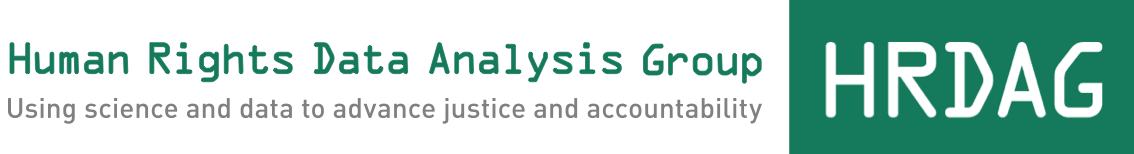

In [1]:
from IPython.display import Image
Image(filename='../data/banner.png')

In [2]:
# dependencies
import re
import pandas as pd
from wand.image import Image
from IPython.display import HTML

In [3]:
# support methods
def read_format(csvf):
    df = pd.read_csv(csvf)
    df['proportion_matched'] = df.percentage_matched.apply(lambda x: round(x/100, 2))
    metrics = ['precision', 'recall', 'f1_score', 'f_beta_score']
    for metric in metrics:
        df[metric] = df[metric].apply(lambda x: round(x, 2))
    return df


def get_results(dfs, filekey):
    results = []
    for df in dfs:
        cut = df.loc[df.filename.str.contains(filekey, flags=re.I)]
        results.append(cut)
    out = pd.concat(results).set_index('model')#.reset_index(drop=True)
    assert out.shape[0] == 4
    return out


def get_html(img_file, label):
    html = f"""
    <img src={img_file} style="display=block; margin:auto"/>
    <pre>
    </pre><p style="text-align: center">
        <b>{label}</b>
    </p>"""
    return html


def get_sized_html(img_file, label, width, height):
    html = f"""
    <img src={img_file} style="display=block; margin:auto" width="{width}" height="{height}"/>
    <pre>
    </pre><p style="text-align: center">
        <b>{label}</b>
    </p>"""
    return html

In [4]:
# main
exhibit_pdf = "../data/Adams_Exhibit Volumes FILED.pdf"
report_pdf = "../data/Police Report.pdf"

# are these the all pages approach bc that worked best?
mixtral_7b = read_format(csvf="../data/Mixtral-8x7B-Instruct-v0.1.csv")
mixtral_22b = read_format(csvf="../data/Mixtral-8x22B-Instruct-v0.1.csv")
claude_sonnet = read_format(csvf="../data/results_claude-3-5-sonnet-20240620.csv")
claude_haiku = read_format(csvf="../data/results_claude-3-haiku-20240307.csv")
results_dfs = [mixtral_7b, mixtral_22b, claude_sonnet, claude_haiku]

# minor formatting of results
rescols = [
    #'model',
    'token_count', 'total_ground_truth',
    'true_positives', 'false_positives',
    'recall','precision',  'f1_score', 'f_beta_score',
    'matched_names', 'unmatched_names',
]

# setup results tables for docs
exhibit_results = get_results(dfs=results_dfs, filekey="Adams")[rescols]
report_results = get_results(dfs=results_dfs, filekey="^Police Report.json")[rescols]

# PDF Preview

As discussed in Part 1, this task uses LLMs to extract officer names from wrongful conviction case files. Prior to processing the documents with the LLMs, each document was labeled with the number of "ground truth" entities available to extract, to support the calculation of the recall score.

In this part, we will deep dive into two PDFs - one with a high recall and one with a low recall - and see if we can come up with some ideas as to why the two scores are so disparate.

Here are our samples:
1. Adams_Exhibit Volumes FILED.pdf
2. Police Report.pdf

Before I dive into the results from each of the 4 LLMs, I want to preview the original docs and see if I can guess which one will have the higher true positive rate.

Upon skimming, I see that the **Exhibit doc** is a scan of a typed form and has a filing stamp from 2015. In total, it has 185 pages. By the first page, I might assume this is the one that processes better of the two. However, by page 4 I can see the document is both slanted and quite blurry; the text appears obscured and in some places I can't quite make out what it says. It might even be a scan of a scan. Across the 185 pages, there's a mixture of structured forms, narrative, and dialgoue.

In reviewing the **Police report doc** from 1988, I see a ton of cursive handwriting and the fields are observably slanted, enough that on some pages the left side is partially cutoff, but it's a notably clearer scan than the **Exhibit doc**. It's also much shorter - only 5 pages total. The cursive might be a tip-off that the police report will be more difficult to extract text and entities from, but I don't have the trouble reading it that I have with the other doc. Not only is it not blurry, but the handwriting appears very neat and consistently formatted. There is some information within structured cells at the top of each page, but most is in narrative format as the body of the page.

Let's bet on the underdog for kicks. Here's the human's hypothesis:
> The LLMs will be able to extract more ground truth entities when processing the cursive Police Report than when processing the blurry Exhibit doc.

## Exhibit doc

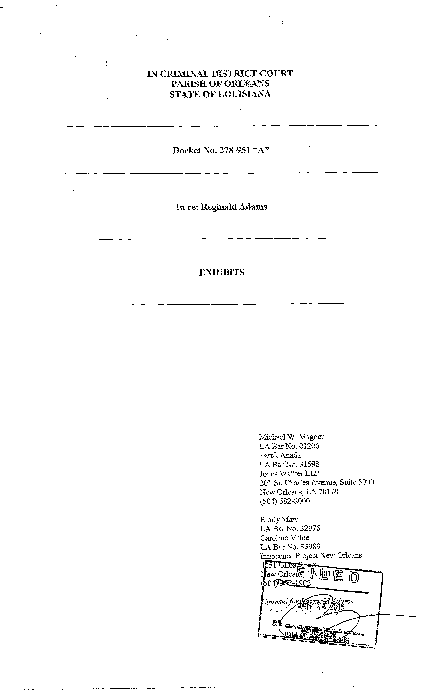

In [5]:
Image(filename=f'{exhibit_pdf}[0]', resolution=50)

## Report doc

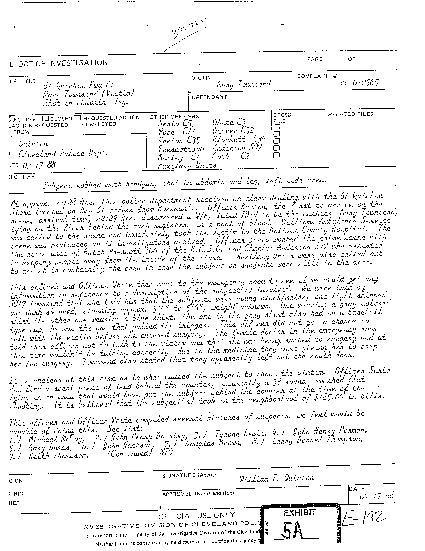

In [6]:
Image(filename=f'{report_pdf}[0]', resolution=50)

# Review results table

## Exhibit doc

In [7]:
exhibit_results.T

model,mistralai/Mixtral-8x7B-Instruct-v0.1,mistralai/Mixtral-8x22B-Instruct-v0.1,claude-3-5-sonnet-20240620,claude-3-haiku-20240307
token_count,102827,102827,102827,102827
total_ground_truth,32,32,32,32
true_positives,31,28,30,29
false_positives,451,204,58,165
recall,0.97,0.88,0.94,0.91
precision,0.06,0.12,0.34,0.15
f1_score,0.12,0.21,0.5,0.26
f_beta_score,0.25,0.39,0.69,0.45
matched_names,"{'davillier', 'gebbia', 'woodall', 'charles fo...","{'davillier', 'gebbia', 'walley goodey', 'char...","{'davillier', 'gebbia', 'walley goodey', 'wood...","{'davillier', 'gebbia', 'walley goodey', 'char..."
unmatched_names,{'walley goodey'},"{'lynn anderson', 'doug gremillion', 'samuels'...","{'samuels', 'carole'}","{'lynn anderson', 'doug gremillion', 'woodall'}"


## Report doc

In [8]:
report_results.T

model,mistralai/Mixtral-8x7B-Instruct-v0.1,mistralai/Mixtral-8x22B-Instruct-v0.1,claude-3-5-sonnet-20240620,claude-3-haiku-20240307
token_count,3748,3748,3748,3748
total_ground_truth,11,11,11,11
true_positives,4,5,5,3
false_positives,28,26,5,26
recall,0.36,0.45,0.45,0.27
precision,0.12,0.16,0.5,0.1
f1_score,0.19,0.24,0.48,0.15
f_beta_score,0.26,0.33,0.46,0.21
matched_names,"{'white', 'serio', 'quinton', 'anthony keeton'}","{'quinton', 'anthony keeton', 'white', 'cobb',...","{'anderson', 'white', 'prescott', 'serio', 'po...","{'white', 'serio', 'anthony keeton'}"
unmatched_names,"{'weaver', 'anderson', 'mosley', 'cobb', 'pres...","{'weaver', 'anderson', 'mosley', 'prescott', '...","{'weaver', 'anthony keeton', 'quinton', 'mosle...","{'weaver', 'quinton', 'anderson', 'mosley', 'c..."


# Discussing results

## Percentage matched

- The **recall score** or **proportion matched** is dramatically different for the two documents. And our bet was wrong! The Report doc had 11 entities to extract and the models' recall scores varied between 27-46% - pretty low even with relatively few in the document and few pages to process. The Exhibit doc had 33 entities to extract over 185 pages and the models recall score was higher across the board _and_ varied less - between 88-97%. This was true for both rounds of processing.
- In an earlier round of processing, **Claude Haiku** had the best recall rate for the Exhibit doc and the worst recall rate for the Report. In this round, it was again the model with the worst recall for the Report doc and one of the low recall scores for the Exhibit doc (though still at a high 88% recall).
- The **Mixtral models** had a difference in recall of roughly 10% but traded places as the higher and lower recall score, where **Mixtral 22b** did slightly worse on the longer Exhibit doc than **Mixtral 7b** but slightly better on the shorter Police Report doc. This was true for both rounds of processing.
- The **Claude models** also traded recall performance in the first round but not in the second. For the Exhibit doc, **Claude Haiku** originally did slightly better than **Claude Sonnet** by about 6% (scoring 97% and 91%, respectively), but in the second round had a recall of 88% to Sonnet's 91%. In the Police report doc, both had a recall below 50% but **Claude Sonnet** outperformed **Claude Haiku** by almost 20% (scoring 46% and 27%, respectively, across both rounds). This suggests the Haiku and Sonnet models are competitive with each other for some documents, but more testing is needed to determine specifically what document features contribute most reliably to recall score.

## False positives
As mentioned in Part 1, entity extraction tasks are generally less susceptible to the negative effects of hallucination, and we can be less concerned about false positives if we engineer the prompt well and mind the results with a little post-processing.

Here's the breakdown of how many true and false positives were extracted from the Exhibit doc (which had references to 32 unique humans):

| model | true positives | false positives |
| :- | :-: | :-: |
| Mixtral 7b | 31 | 451 |
| Claude Haiku | 30 | 165 |
| Claude Sonnet | 29 | 58 |
| Mixtral 22b | 28 | 204 |

- In the results of the longer Exhibit doc, it appears the smaller models (**Mixtral 7b** and **Claude Haiku**) had a more "fast and loose" approach to extraction and included notably more false positives in their results than their more robust peers. In the first round, **Claude Haiku** had the highest count of true matches than any of the 4 models tested, but **Mixtral 7b** took the lead in the second round.
- In the results of the shorter Report doc, that disparity between large and small models was still true for the **Claude models**, but the larger Mixtral model was not much better than its smaller peer.
- The smaller **Claude Haiku** had the least true matches out of all 4 models tested on the Report doc (3 of 11 possible) and tied for the lowest count of true matches on the Exhibit doc (29 of 33 possible).
- **Mixtral 7b** had the highest number of false positives for either document, with more than 14 for every 1 true positive extraction from the Exhibit doc. However, it also had the highest number of true positives on the Exhibit doc.

### Thoughts on identifying and filtering false positives
Many factors go into how productive an LLM's response will be for your use case. Training data, model characteristics (and the related priorities of those developing it) as well as the quality of the available text can all influence the output. But, the prompt you provide an LLM also plays a role in the quality and usability of the results.

As presented in Part 1, the prompt used by models in this session specified the extraction of 3 key features:
1. Officer name
2. Officer role
3. Officer context

An extracted name can always be used in auditing because it should always appear (either partially or fully) in the original text. If it doesn't, where'd the model get it? In this case, including supplementary information like the role and context along with each extracted entity enabled downstream processing to use these fields for filtering out extractions that were not of interest (ie. not actually officers). However, when your processing begins with a PDF - especially one without embedded text - the risk of important context becoming mangled or left out by the text extraction can also factor into how productive the model's results are and how useful or correct the additional role and context info would be to downstream processing.

## Unmatched names

Let's look at the names that were not matched and see if we can find where they appear in the original docs to see if we can source more ideas about why they might've been hard to extract.

### Exhibit doc

#### Most common missed names

- Missed names varied by model used, such that no name was missed by all 4 models or even 3 of the tested models.
- The following names were missed by exactly 2 models tested:
    - "doug gremillion"
    - "lynn anderson"
    - "samuels"
    - "woodall"
- Of the 5 names missed by at least 2 models, 3 of those names were missed by the same 2 models:
    - Mixtral 22b
    - Claude Haiku

#### Most common missed names as they appear in the PDF

In [35]:
with Image(filename="../imgs/woodall_pg22.png") as img:
    img.label("Woodall mentioned on page 22")

TypeError: font must be specified or existing in image

In [9]:
HTML(get_html(img_file="../imgs/woodall_pg22.png", label="Woodall mentioned on page 22"))

In [10]:
HTML(get_html(img_file="../imgs/anderson_gremillion_pg34.png", label="Anderson & Gremillion mentioned on page 34"))

#### Insights
- "Woodall" is only mentioned on page 22 and appears correctly in the JSON for that page: "At 10:00AM, Detectives Gebbia, Venezia, Carole, Davillier and Woodall in company of Sgt. Wayme Cooper returned to the scene." It may be that the name appeared too long after the keyword "Detectives", or that the name is akin to a needle in a 185 page haystack.
- On page 34, "Lynn Anderson" and "Doug Gremillion" are mentioned together. However, in the JSON transcription for this page, they read, "Ypas Anderson and Doug Cremmillion". This might be a good reason to pull in some fuzzy matching in the processing of extracted entities, but the same document also contains highly similar ground truth names, "James Dupuis" and "James Ducos" which are the ground truth names of two different people who happen to both be crime lab photographers who worked on this case.
- The quality of the text extraction was pretty good despite some typo-like errors, and the fact that there were no names missed by more than 2 models could suggest that, for this document, model characteristics or parameters had a greater influence on the results than the quality of the text extraction itself.

### Report doc

#### Most common missed names

- Every model missed the following names in the Report doc:
    - "blockett"
    - "mosley"
    - "weaver"
- 3 of the 4 models missed the following names:
    - "anderson"
    - "cobb"
    - "pope"
    - "prescott"

#### Most common missed names as they appear in the PDF

In [11]:
HTML(get_html(img_file="../imgs/other_officers_pg1.png", label="Other Officers box on first page"))

In [12]:
HTML(get_html(img_file="../imgs/anderson_pg1_pr1.png", label="'Anderson' reference on first page paragraph 1"))

In [13]:
HTML(get_html(img_file="../imgs/prescott_pg1_pr1.png", label="'Prescott' reference on first page paragraph 1"))

#### Insights

- Five of the seven names missed by all or most models appear only once and in the 'Other Officers' box on the first page of the Report doc. It's possible that the LLMs failed to extract these entities correctly because they appeared clustered together in a form-like layout and without individual role prefixes.
- 'Anderson' and 'Prescott' appeared with first and last name and badge number in narrative, but these mentions were not prefixed with a keyword like "Officer" or "Detective" to signal their role.

Reviewing the JSON contents for the first page and where the same headers appear on that page of the original PDF can help us work backwards to what the model processed and further explore what might've gone wrong.

#### First few lines appearing in the JSON

_Note: Emphasis has been added to the headers / distinct groups of information_.

> "The 07 17 88 <font color="#ae13f2"><b>DATE</b></font> 88 010565 E-192 Officer Serio <font color="#ae13f2"><b>RELATED FILES PAGE 1 COMPLAINT #</b></font> We were told by <font color="#ae13f2"><b>EXHIBIT</b></font> William Ambulance Service One wearing a gray coloned <font color="#ae13f2"><b>FILE CROSS</b></font> tabbles' 8. 1 Larry Donnel Thompson, William T. Quinton Auxilary Units were also called out This officer did not get a chance to Many Townsend The female doctor in the emergency room Cobb Blockett C34 White C3 Weaver C32 Officer Keeton, the first to annive on the <font color="#ae13f2"><b>DEFENDANT VICTIM</b></font> Douglas Brown, 308. 7800 <font color="#ae13f2"><b>APPROVED (Name and title) SIGNATURE (Agent)</b></font> Pope Keeton C35 PrescottSob Anderson SO7 <font color="#ae13f2"><b>OFFICIAL USE ONLY</b></font> Serio L5, Morley CI Auxilary Units <font color="#ae13f2"><b>OTHER OFFICERS</b></font> See List: (Continued)"

#### First page of PDF with fields from JSON snippet highlighted

_Note: Emphasis has been added to the headers appearing in JSON snippet above_.

In [14]:
HTML(get_sized_html(img_file="../imgs/report_pg1_highlighted.png", label="First page", width=400, height=600))

#### Insights
- The cursive handwriting style is likely responsible for the misreading of "r" characters as "n", as seen in "Officen White" and "the first to annive."

While English speakers might default to reading a page from left to right and top to bottom, not all languages organize written text like that, and computer programs that extract text from documents are also not bound to that practice.

Based on the order of appearance, it looks like (for the most part) the model would've begun on the lower right of the page and iterated over structured fields from bottom to top and right to left, such that some field values appear before the field name. Possibly relatedly, partial extraction of a field value was common, as evidenced by the line, "The female doctor in the emergency room Cobb Blockett C34 White C3 Weaver C32 Officer Keeton, the first to annive." Three of the top seven unmatched names appear in this line alone and 4 of the officers named in the line show no association with the term "officer" based on how the text was extracted. Given that "Officer White" appears in a later paragraph, it's possible that that appearance is responsible for the match, and that this mention would have otherwise been lost due to partial extraction of the 'Other Officers' field.

# Summary

- Both documents were scans and had a slight slant, but the extracted JSON data was legible and included little noise, which could mean the slant was not an issue for text extraction.
- The JSON data from both documents contained typo-like errors that could be easy for a human to spot but, where they appear in extracted names, could be non-trivial to resolve.
- The cursive handwriting in the Report doc introduced some mild but consistent errors such as the reading of "r" as "n." This seems easier to resolve than the name data since extracted words should match words available in the selected language (in this case, English), but the size of the given text and the language corpus considered would also play a role in how feasible or productive this kind of processing would be in practice.
- The Exhibit doc had some information and pages in a form-like layout, but most of the document was typed and unstructured. As a 185 page court document covering multiple exhibits, it's likely some key information only appeared once as a "Needle in the Haystack", but key involved persons could've been mentioned or even provided testimony over multiple pages, which should increase the available context and resulting odds that those named entities would be extracted. In contrast, the Report doc had some key information and officer mentions that only appeared on the form-like area of the first page and all of the detailed information appeared across five pages of handwritten cursive.

Although the quality of the Exhibit doc appeared like the worse of the two documents reviewed, the quality of the text extraction and resulting model performance in terms of recall were much better than for the Report doc. Because Large Language Models parse available text and collect pieces of contextual information to connect, it makes sense that the document in which the majority of pages have typed text in a single column allowed for more accurate text and entity extraction. However, review of additional documents and those results is needed.